In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from infra.model_base import ModelBase
from infra.train import Metrics, Evaluator, train
from infra.convlstm import ConvLSTMCell
from infra.dataset import ClimateHackDataset

In [4]:
class Nowcaster(ModelBase):
    def __init__(self, *args, **kwargs):
        super(Nowcaster, self).__init__(*args, **kwargs)
        self.encoder = ConvLSTMCell(1, 64, 3)
        self.downsample = torch.nn.Conv2d(64, 24, 1, padding="same")
        self.pool = torch.nn.MaxPool2d(2,2)

    def init_hidden(self, batch_size, in_height, in_width, device):
        h = torch.zeros((batch_size, 64, in_height, in_width), device=device, dtype=torch.float32)
        c = torch.zeros((batch_size, 64, in_height, in_width), device=device, dtype=torch.float32)
        return h, c

    def forward(self, x):
        N, T, H, W = x.shape
        state = self.init_hidden(N, H, W, device=x.device)
        h, c = state
        for i in range(T):
            h, c = self.encoder(x[:, i:i+1], (h, c))
        output = self.downsample(h)
        torch.cuda.empty_cache()
        return self.pool(output)

In [5]:
loss = torch.nn.MSELoss()
model = Nowcaster("./temp/checkpoint")
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [6]:
training_data = ClimateHackDataset("./temp/processed", torch.device('cuda:0'), count=100, train=True)
testing_data = ClimateHackDataset("./temp/processed", torch.device('cuda:0'), count=100, train=False)

In [7]:
model.cuda()
train_loader = torch.utils.data.DataLoader(training_data, batch_size=8)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=8)
def accuracy(y_true, y_pred, y_score):
    return torch.mean(((y_true-y_pred) == 0).to(torch.float16)).item()
metrics = Metrics()
train_loss, train_acc, val_loss, val_acc = train(model, loss, optimizer, train_loader, test_loader , metrics, 5)

══════════ Epoch 1 ══════════
Training pass: 

100%|██████████| 13/13 [02:44<00:00, 12.62s/it]


Validation pass: 

100%|██████████| 13/13 [00:02<00:00,  5.17it/s]


Train Loss: 38866.796875, Val Loss: 17566.72265625
══════════ Epoch 2 ══════════
Training pass: 

100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Validation pass: 

100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


Train Loss: 34645.6015625, Val Loss: 12392.015625
══════════ Epoch 3 ══════════
Training pass: 

100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Validation pass: 

100%|██████████| 13/13 [00:02<00:00,  5.14it/s]


Train Loss: 36891.625, Val Loss: 42958.1640625
══════════ Epoch 4 ══════════
Training pass: 

100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Validation pass: 

100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Train Loss: 43515.20703125, Val Loss: 35659.3046875
══════════ Epoch 5 ══════════
Training pass: 

100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Validation pass: 

100%|██████████| 13/13 [00:02<00:00,  5.13it/s]

Train Loss: 16075.7265625, Val Loss: 37288.84375


<AxesSubplot:>

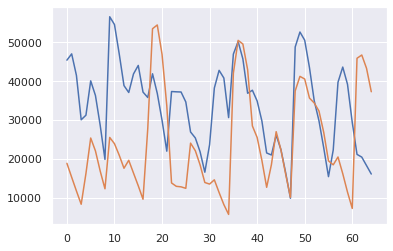

In [8]:
import seaborn as sns
sns.set_theme()
sns.lineplot(x=torch.arange(0, len(train_loss)), y=train_loss)
sns.lineplot(x=torch.arange(0, len(val_loss)), y=val_loss)

<AxesSubplot:>

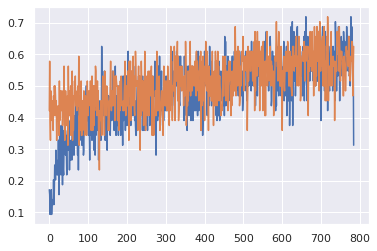

In [27]:
sns.lineplot(x=torch.arange(0, len(train_acc)), y=[acc[0] for acc in train_acc])
sns.lineplot(x=torch.arange(0, len(val_acc)), y=[acc[0] for acc in val_acc])

In [28]:
import matplotlib.pyplot as plt
import random


test_iter = iter(test_loader)
for i in range(random.randint(0,9999)):
    next(test_iter)
model.eval()
with torch.no_grad():
    X,y = next(test_iter)
    pred = model(X)
    cpu = X.clone().cpu()[0]
    cpu *= test_data.std.view(-1,1,1).cpu()
    cpu += test_data.mean.view(-1,1,1).cpu()
    plt.imshow(cpu.permute(1, 2, 0)/255.0)
    print(torch.argmax(pred))
    print(y)

TypeError: 'Tensor' object is not callable

In [29]:
print(model.summary())

Model:
══════════════════════════════════════════════════
conv1: Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same) - 224 parameters
──────────────────────────────────────────────────
bn1: BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) - 16 parameters
──────────────────────────────────────────────────
relu: ReLU() - 0 parameters
──────────────────────────────────────────────────
maxpool: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) - 0 parameters
──────────────────────────────────────────────────
conv2: Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=same) - 2336 parameters
──────────────────────────────────────────────────
bn2: BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) - 64 parameters
──────────────────────────────────────────────────
conv3: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same) - 18496 parameters
────────────────────────────────────────────

In [76]:
import matplotlib.pyplot as plt
import random

test_loader = torch.utils.data.DataLoader(test_data)
test_iter = iter(test_loader)
model.eval()
count = 0
with torch.no_grad():
    for X,y in test_loader:
        pred = model(X)
        if torch.argmax(pred) == y.item():
            count += 1
print(f"{count/10000}")

0.4881
